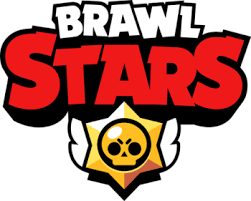

## Brawl Stars Data Science - Predict a win or loss for top players - Fetch the battle data

This script connects with the official Brawl Stars API and retrieves various info about a player's latest matches with the purpose of designing an ML algorithm that will be able to predict if a match will end as a win or loss.

In [1]:
# Install Libraries
!pip install brawlstats

In [2]:
# Import libraries
import brawlstats
import numpy as np
import pandas as pd
from datetime import datetime

# Import functions
from parameters import *  # Change to parameters_template and add your API KEY.
from utils.duplicate_battles import *
from utils.save_battles import *

In [3]:
# Connect with the client using your unique token
client = brawlstats.Client(api_token)

Types of games: {'challenge',
 'championshipChallenge',
 'friendly',
 'ranked',
 'soloRanked',
 'teamRanked',
 'tournament'}

In [4]:
# Get IDs of top players in the world
ids = pd.DataFrame(columns=['name','ID'])
top_players = client.get_rankings(ranking='players', limit=200)
for player in top_players:
    temp_df = pd.DataFrame(data=np.array([player.name, player.tag]).reshape((1,2)),
                           columns=['name','ID'])
    ids = pd.concat([ids, temp_df])
ids.reset_index(drop=True, inplace=True)

In [5]:
ids

,name,ID
0,Hyra,#VLQPVPY
1,TwistiTwik,#2VQ82YGY
2,TTV:Juan_Carlos,#PR9U2JL
3,PeHyeok,#8Y0L90QV8
4,voke.,#LL2RJ2L
...,...,...
195,あちゃゆう,#LQJC9QL2
196,陰キャ長男┃キノキング🍄,#8U8CGY00
197,Uakks,#80L8UUGPR
198,BGP | GGâmêř,#PYURUYPV


In [6]:
all_data = pd.DataFrame(columns=df_columns)

In [7]:
# ids[ids['ID']==i].loc[ids[ids['ID']==i].index[0]]['name']

In [8]:
# For each player, retrieve their match history

for i in ids['ID']:
    
    # Prints for loop
    print('')
    print('**** Scanning player no {} out of {} ****'.format(ids[ids['ID']==i].index[0]+1, len(ids)))
    print('Name: {}, ID: {}'.format(ids[ids['ID']==i].loc[ids[ids['ID']==i].index[0]]['name'], i))
    
    try:
        # Get all the battles for a player
        battles = client.get_battle_logs(i)
        
    except:
        print('This ID is not recognised and will be skipped.')
        continue
    
    # Loop the battles of a player
    for j in range(0,len(battles.raw_data)):
        
        # Check if battle is valid
        valid_battle = True
        
        # First Level of Filtering
        # Not include Boss Fight
        if battles.raw_data[j]['battle']['mode'] == 'bossFight':
            valid_battle = False
        # Not include Robo Rumble
        if battles.raw_data[j]['battle']['mode'] == 'roboRumble':
            valid_battle = False
        # Not include Big Game
        if battles.raw_data[j]['battle']['mode'] == 'bigGame':
            valid_battle = False
        
        # Second Level of Filtering ("type" key is available)
        if valid_battle:
            # Not include friendly battles
            if battles.raw_data[j]['battle']['type'] == 'friendly':
                valid_battle = False
            # Not include tournament battles
            if battles.raw_data[j]['battle']['type'] == 'tournament':
                valid_battle = False
            # Not include Solo Showdown
            if battles.raw_data[j]['battle']['mode'] == 'soloShowdown':
                valid_battle = False
            # Not include Duo Showdown
            if battles.raw_data[j]['battle']['mode'] == 'duoShowdown':
                valid_battle = False
            # All event info should be available
            if len(battles.raw_data[j]['event']) != 3:
                valid_battle = False
        
        # Populate a placeholder df (battle_df) with all the battle information
        if valid_battle:

            # Store the info for the specific battle
            battle_df = pd.DataFrame(data = np.zeros((1,len(df_columns))), columns=df_columns)

            # General
            battle_df['timestamp'] = battles.raw_data[j]['battleTime']
            battle_df['event_id'] = battles.raw_data[j]['event']['id']
            battle_df['mode'] = battles.raw_data[j]['event']['mode']
            battle_df['map'] = battles.raw_data[j]['event']['map']
            battle_df['type'] = battles.raw_data[j]['battle']['type']
            # battle_df['result'] = battles.raw_data[j]['battle']['result']
            
            # Figure out if player is in team 1 or 2
            id_in_team_1 = False
            for k in range(0,3):
                if i == battles.raw_data[j]['battle']['teams'][0][k]['tag']:
                    id_in_team_1 = True
            # battle_df['id_in_tm1'] = id_in_team_1

            # Player specific
            battle_df['pl1_tm1_brawler'] = battles.raw_data[j]['battle']['teams'][0][0]['brawler']['name']
            battle_df['pl1_tm1_brwlr_trop'] = battles.raw_data[j]['battle']['teams'][0][0]['brawler']['trophies']
            battle_df['pl1_tm1_brwlr_pwr'] = battles.raw_data[j]['battle']['teams'][0][0]['brawler']['power']

            battle_df['pl2_tm1_brawler'] = battles.raw_data[j]['battle']['teams'][0][1]['brawler']['name']
            battle_df['pl2_tm1_brwlr_trop'] = battles.raw_data[j]['battle']['teams'][0][1]['brawler']['trophies']
            battle_df['pl2_tm1_brwlr_pwr'] = battles.raw_data[j]['battle']['teams'][0][1]['brawler']['power']

            battle_df['pl3_tm1_brawler'] = battles.raw_data[j]['battle']['teams'][0][2]['brawler']['name']
            battle_df['pl3_tm1_brwlr_trop'] = battles.raw_data[j]['battle']['teams'][0][2]['brawler']['trophies']
            battle_df['pl3_tm1_brwlr_pwr'] = battles.raw_data[j]['battle']['teams'][0][2]['brawler']['power']

            battle_df['pl1_tm2_brawler'] = battles.raw_data[j]['battle']['teams'][1][0]['brawler']['name']
            battle_df['pl1_tm2_brwlr_trop'] = battles.raw_data[j]['battle']['teams'][1][0]['brawler']['trophies']
            battle_df['pl1_tm2_brwlr_pwr'] = battles.raw_data[j]['battle']['teams'][1][0]['brawler']['power']

            battle_df['pl2_tm2_brawler'] = battles.raw_data[j]['battle']['teams'][1][1]['brawler']['name']
            battle_df['pl2_tm2_brwlr_trop'] = battles.raw_data[j]['battle']['teams'][1][1]['brawler']['trophies']
            battle_df['pl2_tm2_brwlr_pwr'] = battles.raw_data[j]['battle']['teams'][1][1]['brawler']['power']

            battle_df['pl3_tm2_brawler'] = battles.raw_data[j]['battle']['teams'][1][2]['brawler']['name']
            battle_df['pl3_tm2_brwlr_trop'] = battles.raw_data[j]['battle']['teams'][1][2]['brawler']['trophies']
            battle_df['pl3_tm2_brwlr_pwr'] = battles.raw_data[j]['battle']['teams'][1][2]['brawler']['power']

            # Check if team 1 won
            tm1_win = False
            if (id_in_team_1 == True) and (battles.raw_data[j]['battle']['result'] == 'victory'):
                tm1_win = True
            if (id_in_team_1 == False) and (battles.raw_data[j]['battle']['result'] == 'defeat'):
                tm1_win = True

            battle_df['tm1_win'] = tm1_win
            
            # Add this battle to the df with all the battles
            all_data = pd.concat([all_data, battle_df])
            
            all_data.reset_index(drop=True, inplace=True)


**** Scanning player no 1 out of 200 ****
Name: Hyra, ID: #VLQPVPY

**** Scanning player no 2 out of 200 ****
Name: TwistiTwik, ID: #2VQ82YGY

**** Scanning player no 3 out of 200 ****
Name: TTV:Juan_Carlos, ID: #PR9U2JL

**** Scanning player no 4 out of 200 ****
Name: PeHyeok, ID: #8Y0L90QV8

**** Scanning player no 5 out of 200 ****
Name: voke., ID: #LL2RJ2L

**** Scanning player no 6 out of 200 ****
Name: PS | VitalShark, ID: #YGU20CRG

**** Scanning player no 7 out of 200 ****
Name: 기자라인YT, ID: #Y0RY2GR9

**** Scanning player no 8 out of 200 ****
Name: ほーぷ💖, ID: #89R29VUU8

**** Scanning player no 9 out of 200 ****
Name: Super, ID: #2JRJJVYP2

**** Scanning player no 10 out of 200 ****
Name: 🕸️Dêly🕷️, ID: #VQQ00PJL

**** Scanning player no 11 out of 200 ****
Name: Milk Jug, ID: #9Q009VCJ

**** Scanning player no 12 out of 200 ****
Name: PTG|KarmaDavid, ID: #22L20GPL8

**** Scanning player no 13 out of 200 ****
Name: Lachkid, ID: #LCP2Y2Q

**** Scanning player no 14 out of 200 ****


**** Scanning player no 107 out of 200 ****
Name: MBC|TøxicWin, ID: #V8VY0VLU

**** Scanning player no 108 out of 200 ****
Name: 🎭|Dᴀɴɪ, ID: #PLCY9YC0

**** Scanning player no 109 out of 200 ****
Name: あみせとら🌱, ID: #2UVG8P9GL

**** Scanning player no 110 out of 200 ****
Name: ST|Bankrupt:(, ID: #RU2CUVLR

**** Scanning player no 111 out of 200 ****
Name: louis, ID: #CG2LGYUC

**** Scanning player no 112 out of 200 ****
Name: 藤| Fuji |原, ID: #P9G2R98QY

**** Scanning player no 113 out of 200 ****
Name: Sterling♡, ID: #U2JQPJ0R

**** Scanning player no 114 out of 200 ****
Name: QLS|Meliodas ☢️, ID: #CPPV2PQG

**** Scanning player no 115 out of 200 ****
Name: EP|Evan, ID: #9P2G9R2V

**** Scanning player no 116 out of 200 ****
Name: Genji ❀, ID: #RC0P8VL

**** Scanning player no 117 out of 200 ****
Name: kkuba, ID: #LR08G9C8

**** Scanning player no 118 out of 200 ****
Name: Jackstyle™️🦁, ID: #9RLRPGGL

**** Scanning player no 119 out of 200 ****
Name: Jくん。, ID: #2PYVVR02C

**** Scanning p

In [9]:
battles = client.get_battle_logs(i)

In [10]:
# pd.set_option('display.max_rows', 4000)
# pd.set_option('display.max_columns', 500)

In [11]:
all_data.sort_values(by='timestamp', inplace=True)

In [12]:
all_data['type'].value_counts()

ranked        2818
soloRanked      42
teamRanked      33
Name: type, dtype: int64

In [13]:
# Keep only ladder games for simplicity
all_data = all_data[all_data['type']=='ranked']

In [14]:
# Remove duplicate battles with the relevant function
all_data = remove_duplicate_battles(all_data, verbose)

323 out of 2818 Battles removed. 2495 Battles remaining.


In [15]:
# Reset index to prepare for saving
all_data.reset_index(drop=True, inplace=True)

In [16]:
# Drop columns that are not needed, in order to save space
all_data.drop(columns = col_to_drop, inplace=True)

In [17]:
all_data

,mode,map,type,pl1_tm1_brawler,pl1_tm1_brwlr_trop,pl1_tm1_brwlr_pwr,pl2_tm1_brawler,pl2_tm1_brwlr_trop,pl2_tm1_brwlr_pwr,pl3_tm1_brawler,...,pl1_tm2_brwlr_trop,pl1_tm2_brwlr_pwr,pl2_tm2_brawler,pl2_tm2_brwlr_trop,pl2_tm2_brwlr_pwr,pl3_tm2_brawler,pl3_tm2_brwlr_trop,pl3_tm2_brwlr_pwr,tm1_win,unq_battle_id
0,brawlBall,Pinball Dreams,ranked,TARA,957,10,SQUEAK,891,10,MORTIS,...,932,10,MORTIS,897,10,SQUEAK,932,10,True,20210825T112035.000Z_15000118_5430
1,brawlBall,Pinball Dreams,ranked,BELLE,873,10,DARRYL,950,10,MORTIS,...,963,10,SQUEAK,898,10,MORTIS,805,10,True,20210825T112526.000Z_15000118_5357
2,brawlBall,Pinball Dreams,ranked,TARA,953,10,SQUEAK,889,10,MORTIS,...,873,10,FRANK,986,10,MORTIS,888,10,True,20210825T112915.000Z_15000118_5374
3,brawlBall,Pinball Dreams,ranked,SQUEAK,896,10,TARA,959,10,STU,...,950,10,SURGE,960,10,BROCK,942,10,True,20210825T113226.000Z_15000118_5647
4,brawlBall,Pinball Dreams,ranked,FRANK,749,10,BUZZ,780,10,POCO,...,781,10,GRIFF,831,10,MORTIS,775,10,False,20210825T125955.000Z_15000118_4701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,siege,Mecha Match,ranked,POCO,736,10,BELLE,782,10,BIBI,...,761,10,TICK,811,10,POCO,876,10,True,20210828T133726.000Z_15000141_4664
2491,siege,Mecha Match,ranked,8-BIT,796,10,SANDY,787,10,PIPER,...,1052,10,AMBER,912,10,GENE,954,10,False,20210828T133728.000Z_15000141_5292
2492,brawlBall,Sticky Notes,ranked,BROCK,995,10,AMBER,897,10,CROW,...,948,10,BIBI,734,10,CROW,799,10,False,20210828T133758.000Z_15000413_5341
2493,brawlBall,Sticky Notes,ranked,TARA,1104,10,BROCK,1016,10,SPIKE,...,948,10,BO,797,10,MORTIS,814,10,True,20210828T133807.000Z_15000413_5692


In [18]:
save_battles(all_data, loc, verbose)

File saved in location: data/battles_08_28_2021_15_38_29.csv
